<a href="https://colab.research.google.com/github/destello501/destello501.github.io/blob/main/Blind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#panda nos permite manipular el archivo csv https://pandas.pydata.org
import pandas as pd
#numpy nos permite hacer operaciones usando vectores https://numpy.org
import numpy as np
#plotly nos permite crear graficas interactivas https://plotly.com/python/
import plotly.express as px
%matplotlib inline
#usamos la liga que está directamente en la página.
particles = pd.read_csv('https://raw.githubusercontent.com/ProgramasParaFisicaDeParticulas/blindsampleanalysiswithcsv3-destello501/refs/heads/main/Sample3.csv',delimiter=',')
particles.head()


,Run,Event,type1,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,165617,75206813,G,10.1623,0.4763,-8.5164,5.5231,8.5297,0.6091,-1.5149,-1,G,19.7754,2.7508,-13.9871,13.7059,14.2550,0.8539,-1.3766,1
1,165617,75678475,G,15.8799,15.0618,-1.6658,-4.7464,15.1536,-0.3083,-0.1102,1,G,11.9338,11.9084,-0.7670,-0.0851,11.9330,-0.0071,-0.0643,-1
2,165617,74428554,G,21.8279,-6.2214,11.0845,17.7447,12.7111,1.1357,2.0823,-1,G,36.6513,-10.6874,15.0692,31.6544,18.4743,1.3076,2.1877,1
3,165617,75193169,G,19.4923,2.7612,-5.5769,-18.4719,6.2230,-1.8084,-1.1111,1,G,14.9334,1.5525,-6.1254,-13.5302,6.3190,-1.5050,-1.3226,-1
4,165617,74832715,G,8.0972,4.6127,-1.8389,6.3949,4.9657,1.0710,-0.3793,-1,T,3.5131,-0.5305,0.6880,3.4024,0.8688,2.0742,2.2276,1


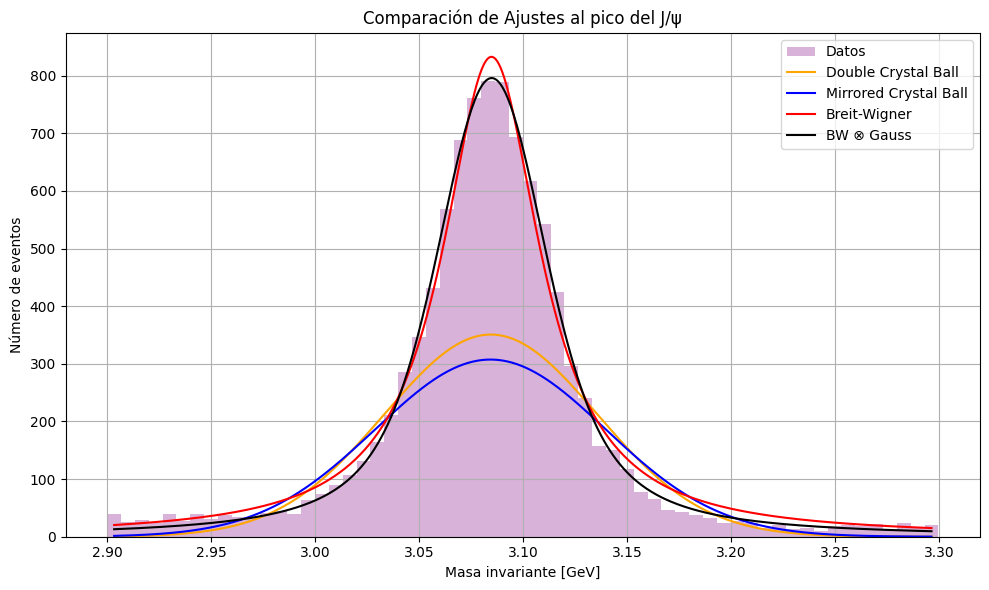

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import voigt_profile

# Se espera que la variable 'particles' ya esté cargada en el entorno del usuario.
# Aquí solo definimos la lógica usando datos reales del usuario.

# Calcular la masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros físicos (sin pt)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Región del J/ψ
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Funciones de ajuste
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)
    mask_left = t < -alphaL
    mask_right = t > alphaR
    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center]**2)
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL**2 / 2) * safe_base_left ** -nL
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR**2 / 2) * safe_base_right ** -nR
    return result

def mirrored_crystal_ball(x, A, mu, sigma, alpha, n):
    t = (x - mu) / sigma
    result = np.zeros_like(t)
    mask_left = t < -alpha
    mask_right = t > alpha
    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)
    z_left = np.maximum(n / abs(alpha) - abs(t[mask_left]), 1e-6)
    result[mask_left] = A * (n / abs(alpha)) ** n * np.exp(-alpha ** 2 / 2) * z_left ** -n
    z_right = np.maximum(n / abs(alpha) - abs(t[mask_right]), 1e-6)
    result[mask_right] = A * (n / abs(alpha)) ** n * np.exp(-alpha ** 2 / 2) * z_right ** -n
    return result

def breit_wigner(x, A, mu, gamma):
    return A * gamma**2 / ((x - mu)**2 + (gamma/2)**2)

def voigt(x, A, mu, gamma, sigma):
    return A * voigt_profile(x - mu, sigma, gamma)

# Ajustes
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)

popt_dscb, _ = curve_fit(double_crystal_ball, bin_centers, hist_values,
                         p0=[np.max(hist_values), 3.1, 0.02, 1.5, 3, 1.5, 3],
                         bounds=([0, 3.05, 0.005, 0.5, 1.1, 0.5, 1.1],
                                 [np.inf, 3.15, 0.08, 5, 10, 5, 10]),
                         maxfev=300000)
y_dscb = double_crystal_ball(x_fit, *popt_dscb)

popt_mcb, _ = curve_fit(mirrored_crystal_ball, bin_centers, hist_values,
                        p0=[np.max(hist_values), 3.1, 0.02, 1.5, 3],
                        bounds=([0, 3.05, 0.001, 0.5, 1.1],
                                [np.inf, 3.15, 0.1, 5.0, 10.0]),
                        maxfev=100000)
y_mcb = mirrored_crystal_ball(x_fit, *popt_mcb)

popt_bw, _ = curve_fit(breit_wigner, bin_centers, hist_values,
                       p0=[np.max(hist_values), 3.1, 0.1],
                       bounds=([0, 3.05, 0.001], [np.inf, 3.15, 0.1]),
                       maxfev=100000)
y_bw = breit_wigner(x_fit, *popt_bw)

popt_voigt, _ = curve_fit(voigt, bin_centers, hist_values,
                          p0=[np.max(hist_values), 3.1, 0.01, 0.01],
                          bounds=([0, 3.05, 1e-4, 1e-4], [np.inf, 3.15, 0.2, 0.1]),
                          maxfev=100000)
y_voigt = voigt(x_fit, *popt_voigt)

# Gráfica de comparación
plt.figure(figsize=(10, 6))
plt.hist(selected_data, bins=60, alpha=0.3, label='Datos', color='purple')
plt.plot(x_fit, y_dscb, label='Double Crystal Ball', color='orange')
plt.plot(x_fit, y_mcb, label='Mirrored Crystal Ball', color='blue')
plt.plot(x_fit, y_bw, label='Breit-Wigner', color='red')
plt.plot(x_fit, y_voigt, label='BW ⊗ Gauss', color='black')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Comparación de Ajustes al pico del J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Número total de eventos (sin filtros): 20000
Número de eventos con filtros aplicados (sin recorte de masa): 17240


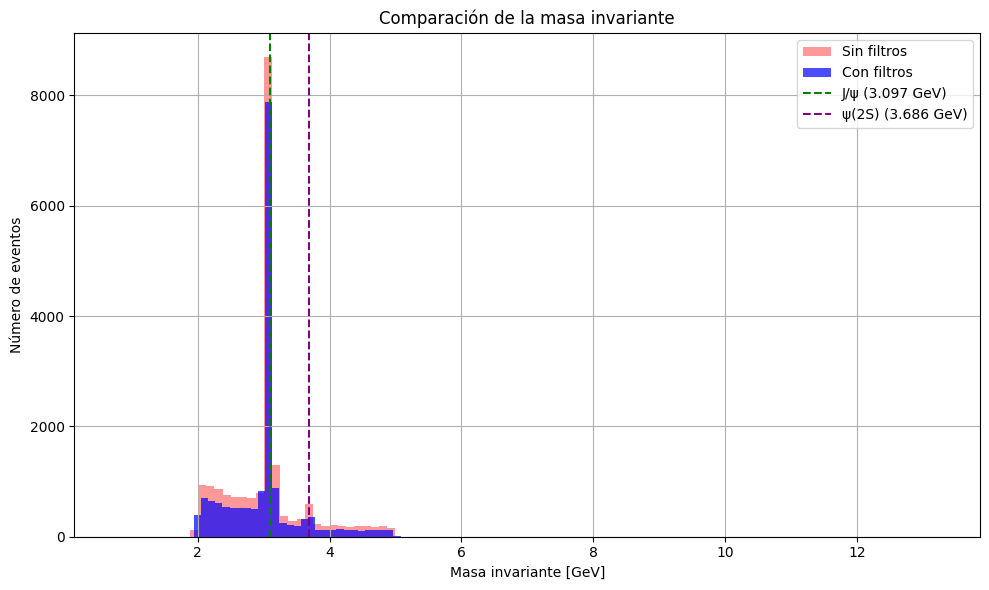

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la masa invariante sin filtros
delta_eta_total = particles['eta1'] - particles['eta2']
delta_phi_total = particles['phi1'] - particles['phi2']
mass_squared_total = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta_total) - np.cos(delta_phi_total))
particles['invariant_mass'] = np.sqrt(mass_squared_total)

# Datos sin filtros
mass_all = particles['invariant_mass']

# Aplicar filtros (excepto masa)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Datos con filtros SIN recorte en la masa
mass_filtered = filtered['invariant_mass']

# Mostrar cantidad de eventos
print("Número total de eventos (sin filtros):", len(mass_all))
print("Número de eventos con filtros aplicados (sin recorte de masa):", len(mass_filtered))

# Graficar comparación
plt.figure(figsize=(10, 6))
plt.hist(mass_all, bins=100, alpha=0.4, label='Sin filtros', color='red')
plt.hist(mass_filtered, bins=100, alpha=0.7, label='Con filtros', color='blue')

# Líneas verticales en J/ψ y ψ(2S)
plt.axvline(x=3.097, color='green', linestyle='--', label='J/ψ (3.097 GeV)')
plt.axvline(x=3.686, color='purple', linestyle='--', label='ψ(2S) (3.686 GeV)')

# Etiquetas
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Comparación de la masa invariante')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Número total de eventos (sin filtros): 20000
Número de eventos con filtros aplicados (sin recorte de masa): 17240


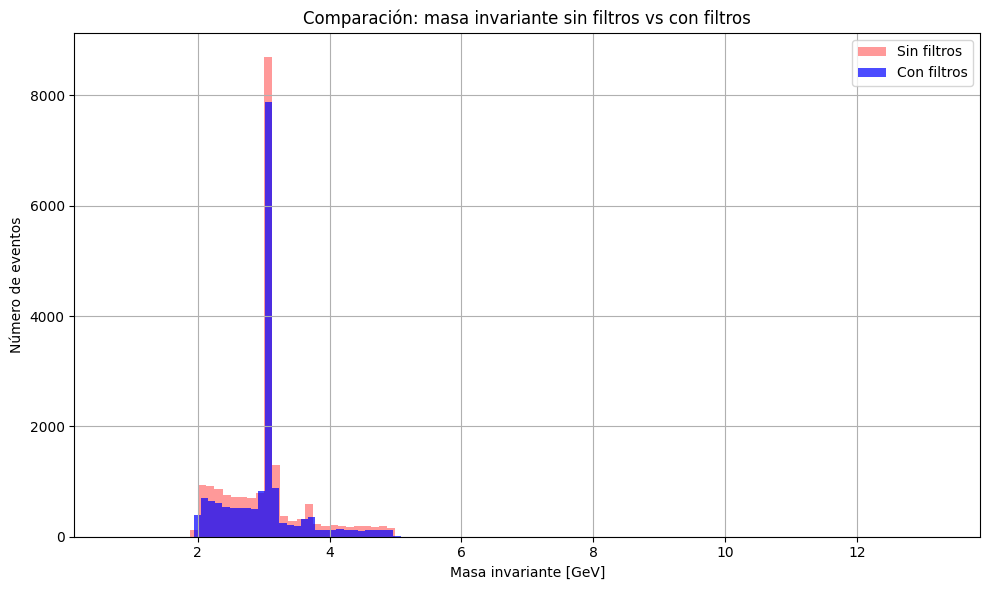

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la masa invariante sin filtros
delta_eta_total = particles['eta1'] - particles['eta2']
delta_phi_total = particles['phi1'] - particles['phi2']
mass_squared_total = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta_total) - np.cos(delta_phi_total))
particles['invariant_mass'] = np.sqrt(mass_squared_total)

# Datos sin filtros
mass_all = particles['invariant_mass']

# Aplicar filtros (excepto masa)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Datos con filtros SIN recorte en la masa
mass_filtered = filtered['invariant_mass']

# Mostrar cantidad de eventos
print("Número total de eventos (sin filtros):", len(mass_all))
print("Número de eventos con filtros aplicados (sin recorte de masa):", len(mass_filtered))

# Graficar comparación
plt.figure(figsize=(10, 6))
plt.hist(mass_all, bins=100, alpha=0.4, label='Sin filtros', color='red')
plt.hist(mass_filtered, bins=100, alpha=0.7, label='Con filtros', color='blue')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Comparación: masa invariante sin filtros vs con filtros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


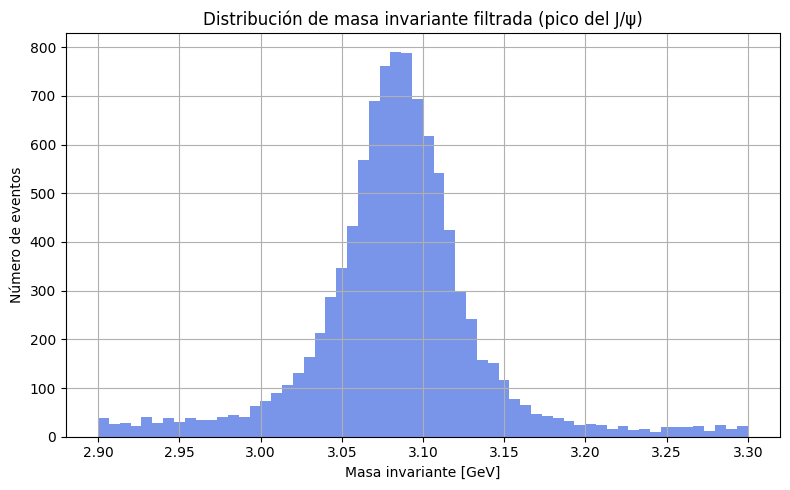

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros (como has usado antes)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Seleccionar solo la región del J/ψ
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
mass_filtered = filtered[region]['invariant_mass']

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(mass_filtered, bins=60, color='royalblue', alpha=0.7)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Distribución de masa invariante filtrada (pico del J/ψ)')
plt.grid(True)
plt.tight_layout()
plt.show()


Número total de eventos (sin filtros): 20000
Número de eventos con filtros (masa entre 2.9 y 3.3 GeV): 9837


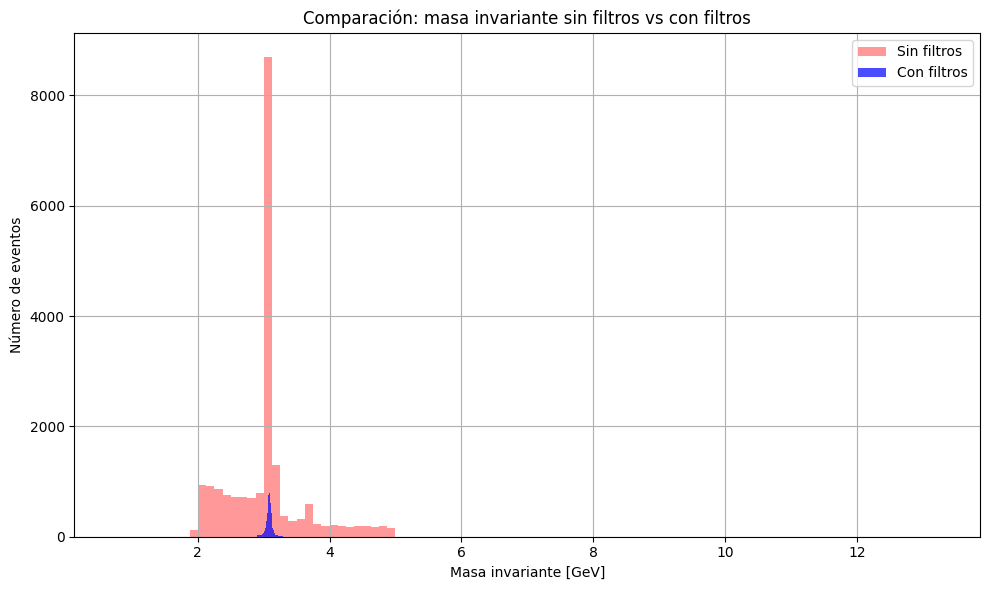

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la masa invariante sin filtros
delta_eta_total = particles['eta1'] - particles['eta2']
delta_phi_total = particles['phi1'] - particles['phi2']
mass_squared_total = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta_total) - np.cos(delta_phi_total))
particles['invariant_mass'] = np.sqrt(mass_squared_total)

# Datos sin filtros
mass_all = particles['invariant_mass']

# Aplicar filtros
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Datos con filtros
mass_filtered = filtered[
    (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
]['invariant_mass']

# Mostrar cantidad de eventos
print("Número total de eventos (sin filtros):", len(mass_all))
print("Número de eventos con filtros (masa entre 2.9 y 3.3 GeV):", len(mass_filtered))

# Graficar comparación
plt.figure(figsize=(10, 6))
plt.hist(mass_all, bins=100, alpha=0.4, label='Sin filtros', color='red')
plt.hist(mass_filtered, bins=60, alpha=0.7, label='Con filtros', color='blue')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Comparación: masa invariante sin filtros vs con filtros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 307.437123 ± 49.765415
mu = 3.084303 ± 0.010355
sigma = 0.055401 ± 0.010356
alpha = 3.828638 ± 0.000000
n = 1.553823 ± 0.000000

Masa central (mu) = 3.084303 ± 0.010355 GeV
Ancho (sigma) = 0.055401 ± 0.010356 GeV
Error cuadrático medio (MSE): 22304.714412


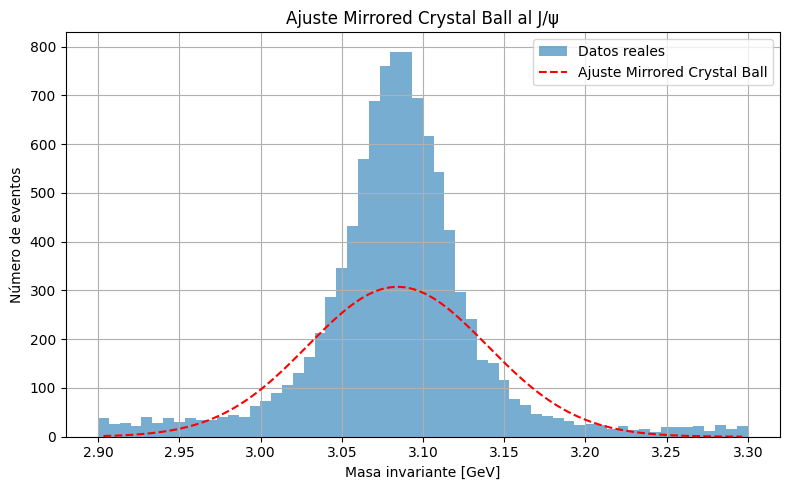

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros sin pt
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Región centrada en el pico del J/ψ
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Mirrored Crystal Ball
def mirrored_crystal_ball(x, A, mu, sigma, alpha, n):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alpha
    mask_right = t > alpha
    mask_center = (~mask_left) & (~mask_right)

    # Centro: gaussiana
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    # Lado izquierdo
    z_left = n / abs(alpha) - abs(t[mask_left])
    z_left = np.maximum(z_left, 1e-6)  # para evitar valores negativos
    result[mask_left] = A * (n / abs(alpha)) ** n * np.exp(-alpha ** 2 / 2) * z_left ** -n

    # Lado derecho
    z_right = n / abs(alpha) - abs(t[mask_right])
    z_right = np.maximum(z_right, 1e-6)
    result[mask_right] = A * (n / abs(alpha)) ** n * np.exp(-alpha ** 2 / 2) * z_right ** -n

    return result

# Ajuste
p0 = [np.max(hist_values), 3.1, 0.02, 1.5, 3.0]
bounds = ([0, 3.05, 0.001, 0.5, 1.1], [np.inf, 3.15, 0.1, 5.0, 10.0])

popt, pcov = curve_fit(
    mirrored_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=bounds,
    maxfev=100000
)
perr = np.sqrt(np.diag(pcov))

# Calcular MSE
fitted_values = mirrored_crystal_ball(bin_centers, *popt)
mse = np.mean((hist_values - fitted_values) ** 2)

# Resultados
param_names = ['A', 'mu', 'sigma', 'alpha', 'n']
for name, val, err in zip(param_names, popt, perr):
    print(f"{name} = {val:.6f} ± {err:.6f}")
print("\nMasa central (mu) = {:.6f} ± {:.6f} GeV".format(popt[1], perr[1]))
print("Ancho (sigma) = {:.6f} ± {:.6f} GeV".format(popt[2], perr[2]))
print("Error cuadrático medio (MSE): {:.6f}".format(mse))

# Gráfica
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=60, alpha=0.6, label='Datos reales')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(x_fit, mirrored_crystal_ball(x_fit, *popt), 'r--', label='Ajuste Mirrored Crystal Ball')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Mirrored Crystal Ball al J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 69.159755 ± 0.761314
mu = 3.084889 ± 0.000236 GeV
gamma (ancho BW) = 0.019176 ± 0.000931 GeV
sigma (resolución detector) = 0.016961 ± 0.000862 GeV
Error Cuadrático Medio (ECM): 137.3068


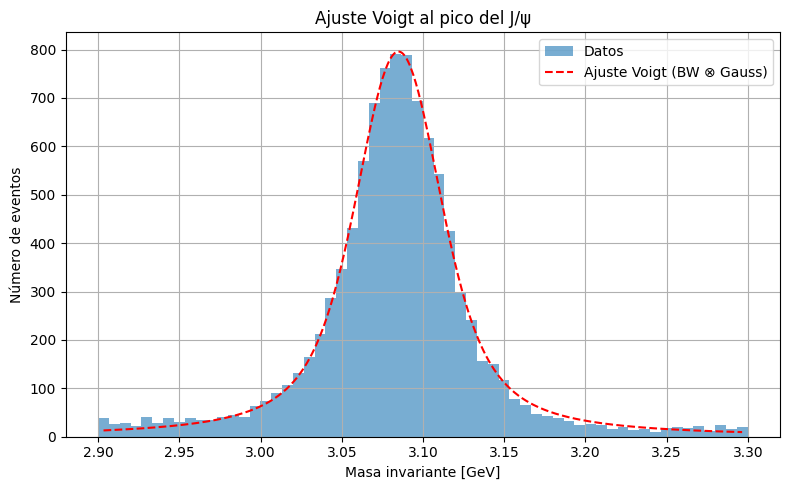

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import voigt_profile

# Calcular la masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros (sin pt)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Pico del J/ψ
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Voigt: convolución Breit-Wigner ⊗ Gaussiana
def voigt(x, A, mu, gamma, sigma):
    return A * voigt_profile(x - mu, sigma, gamma)

# Valores iniciales y límites razonables
p0 = [np.max(hist_values), 3.1, 0.01, 0.01]  # A, mu, gamma, sigma
bounds = (
    [0, 3.05, 1e-4, 1e-4],  # inferiores
    [np.inf, 3.15, 0.2, 0.1]  # superiores
)

# Ajuste
popt, pcov = curve_fit(voigt, bin_centers, hist_values, p0=p0, bounds=bounds, maxfev=100000)
perr = np.sqrt(np.diag(pcov))

# Resultados
print(f"A = {popt[0]:.6f} ± {perr[0]:.6f}")
print(f"mu = {popt[1]:.6f} ± {perr[1]:.6f} GeV")
print(f"gamma (ancho BW) = {popt[2]:.6f} ± {perr[2]:.6f} GeV")
print(f"sigma (resolución detector) = {popt[3]:.6f} ± {perr[3]:.6f} GeV")

# Cálculo del Error Cuadrático Medio (ECM)
residuals = hist_values - voigt(bin_centers, *popt)
mse = np.mean(residuals**2)
print(f"Error Cuadrático Medio (ECM): {mse:.4f}")

# Gráfica
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(x_fit, voigt(x_fit, *popt), 'r--', label='Ajuste Voigt (BW ⊗ Gauss)')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Voigt al pico del J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Error Cuadrático Medio (ECM) del ajuste DSCB: 17955.3108
A = 350.800224 ± 47.341194
mu = 3.084453 ± 0.007969
sigma = 0.051138 ± 0.007969
alphaL = 3.747653 ± 0.000000
nL = 1.241853 ± 0.000000
alphaR = 4.144874 ± 0.000000
nR = 1.111373 ± 0.000000

Masa central (mu) = 3.084453 ± 0.007969 GeV
Ancho (sigma) = 0.051138 ± 0.007969 GeV


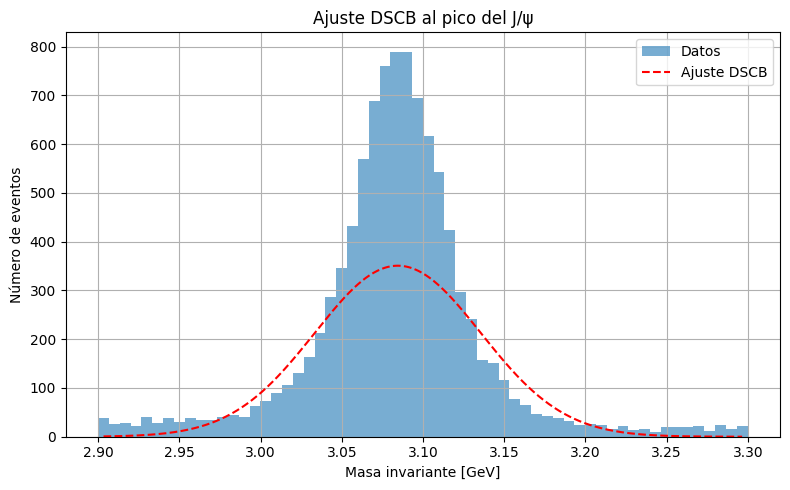

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros (sin corte en pt)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Región centrada (pico del J/ψ)
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función DSCB
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL**2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR**2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center]**2)

    return result

# Valores iniciales y límites
p0 = [np.max(hist_values), 3.1, 0.02, 1.5, 3, 1.5, 3]
lower_bounds = [0, 3.05, 0.005, 0.5, 1.1, 0.5, 1.1]
upper_bounds = [np.inf, 3.15, 0.08, 5, 10, 5, 10]

# Ajuste
popt, pcov = curve_fit(
    double_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=300000
)

# ECM
residuals = hist_values - double_crystal_ball(bin_centers, *popt)
ecm = np.mean(residuals**2)
print(f"Error Cuadrático Medio (ECM) del ajuste DSCB: {ecm:.4f}")

# Resultados
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR']
param_errors = np.sqrt(np.diag(pcov))

for name, val, err in zip(param_names, popt, param_errors):
    print(f"{name} = {val:.6f} ± {err:.6f}")

print(f"\nMasa central (mu) = {popt[1]:.6f} ± {param_errors[1]:.6f} GeV")
print(f"Ancho (sigma) = {popt[2]:.6f} ± {param_errors[2]:.6f} GeV")

# Gráfica
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(x_fit, double_crystal_ball(x_fit, *popt), 'r--', label='Ajuste DSCB')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste DSCB al pico del J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 208.207160 ± 3.064614
mu = 3.084795 ± 0.000422 GeV
gamma = 0.057382 ± 0.001200 GeV
Error Cuadrático Medio (ECM): 481.6708


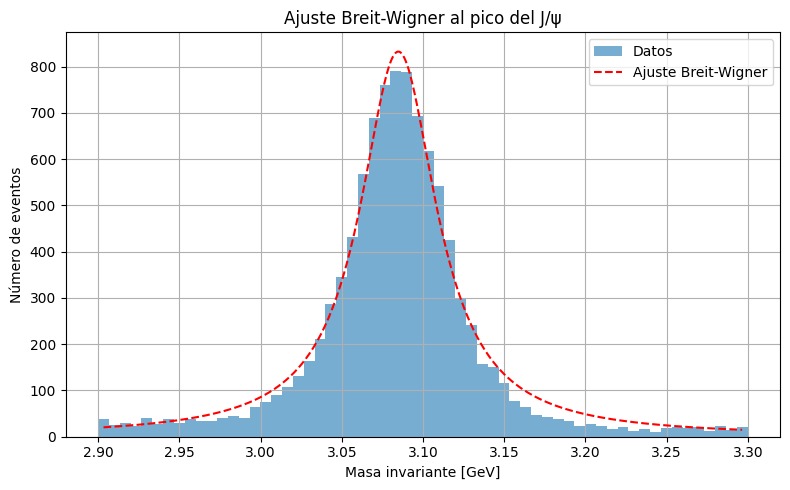

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular la masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros sin pt
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Selección de la región del J/ψ
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Breit-Wigner
def breit_wigner(x, A, mu, gamma):
    return A * gamma**2 / ((x - mu)**2 + (gamma/2)**2)

# Parámetros iniciales y ajuste
p0 = [np.max(hist_values), 3.1, 0.1]
bounds = ([0, 3.05, 0.001], [np.inf, 3.15, 0.1])

popt, pcov = curve_fit(breit_wigner, bin_centers, hist_values, p0=p0, bounds=bounds, maxfev=100000)

# Errores
perr = np.sqrt(np.diag(pcov))

# Resultados
print(f"A = {popt[0]:.6f} ± {perr[0]:.6f}")
print(f"mu = {popt[1]:.6f} ± {perr[1]:.6f} GeV")
print(f"gamma = {popt[2]:.6f} ± {perr[2]:.6f} GeV")

# Error Cuadrático Medio (ECM)
ajuste = breit_wigner(bin_centers, *popt)
ecm = np.mean((hist_values - ajuste)**2)
print(f"Error Cuadrático Medio (ECM): {ecm:.4f}")

# Gráfica
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(x_fit, breit_wigner(x_fit, *popt), 'r--', label='Ajuste Breit-Wigner')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Breit-Wigner al pico del J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
fig_5=px.histogram(particles['eta1'],particles['eta1'])
fig_5.show()

In [9]:
fig_5=px.histogram(particles['pt1'],particles['pt1'])
fig_5.show()